# Loading data

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [171]:
data = pd.read_csv('dataset.txt' , sep = '\t' , names = ['LABEL' , 'MESSAGE'])

data.head(5)

,LABEL,MESSAGE
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [172]:
print(f'Shape of the dataset is {data.shape}')

Shape of the dataset is (5572, 2)


# Explrartory Data Analysis (EDA) 

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   LABEL    5572 non-null   object
 1   MESSAGE  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [174]:
data.describe(include = 'object')

,LABEL,MESSAGE
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [175]:
data['LABEL'].value_counts()

ham     4825
spam     747
Name: LABEL, dtype: int64

In [176]:
data['LABEL'] = data['LABEL'].map({'ham' : 0 ,
                                   'spam' : 1}) 

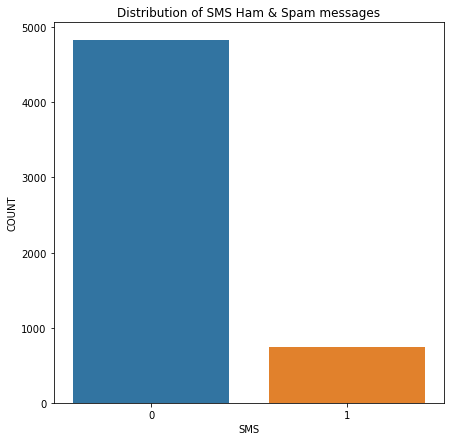

In [177]:
plt.figure(figsize = (7,7))
a = sns.countplot(x = 'LABEL' , data = data)
b = plt.title("Distribution of SMS Ham & Spam messages" )
b = plt.xlabel('SMS')
b = plt.ylabel('COUNT')
plt.show()

#### Insights
- There are non-null values
- We have Imbalance in the dataset spam 10% and ham messages are 90% of tootal dataset

# Data Preprocessing

In [178]:
spamMessage = data[data['LABEL'] == 1]
hamMessage = data[data['LABEL'] == 0] 

numSpam = len(spamMessage)
numHam = len(hamMessage)

count = round(numHam/numSpam)

In [179]:
spamMessageAugmentation = pd.DataFrame()

for i in range (count-3) :
    spamMessageAugmentation = pd.concat([spamMessageAugmentation , spamMessage], axis = 0)

data = pd.concat([data , spamMessageAugmentation ], axis = 0)

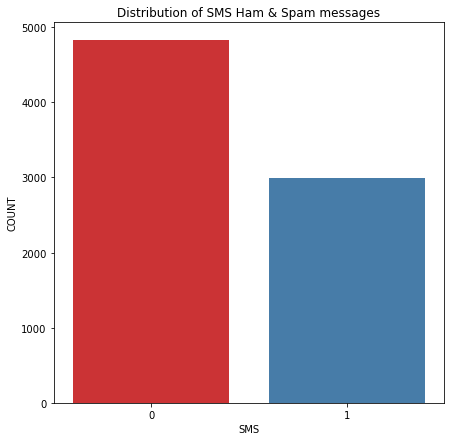

In [180]:
plt.figure(figsize = (7,7))
a = sns.countplot(x = 'LABEL' , data = data , palette = ("Set1"))
b = plt.title("Distribution of SMS Ham & Spam messages" )
b = plt.xlabel('SMS')
b = plt.ylabel('COUNT')
plt.show()

In [181]:
data['WORDCOUNT'] = data['MESSAGE'].apply(lambda x : len(x.split()))

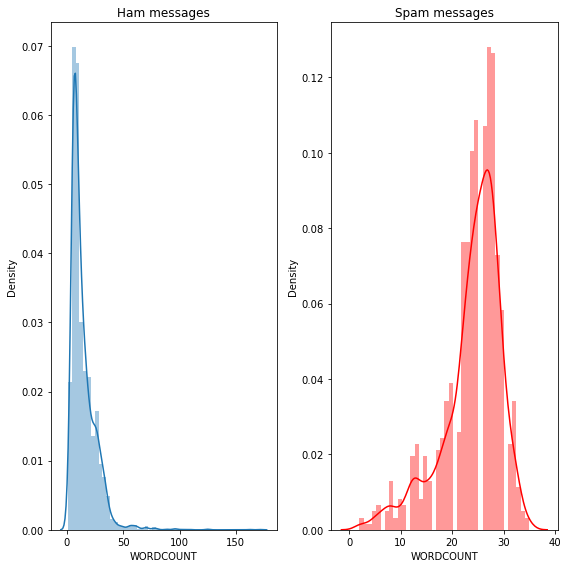

In [182]:
plt.figure(figsize = (8,8))

p = plt.subplot(1,2,1)
a = sns.distplot(a = data[data['LABEL']==0].WORDCOUNT )
p = plt.title('Ham messages')

plt.subplot(1,2,2)
b = sns.distplot(a = data[data['LABEL']==1].WORDCOUNT, color ='red')
p = plt.title('Spam messages')

plt.tight_layout()
plt.show()

#### Insights
- Wordcount of Ham messages almost under 25 word
- Wordcount of Spam messages between 10 to 35 word

In [183]:
def fun_currency(x):
      symbols = ['€', '$', '¥', '£', '₹']
      for i in symbols :
          if i in x :
              return 1
      return 0
  
data['CURRENCY'] = data['MESSAGE'].apply(fun_currency)

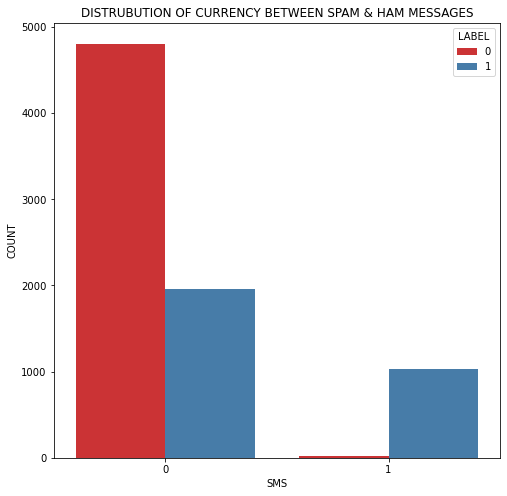

In [184]:
plt.figure(figsize=(8,8))
a = sns.countplot(x = 'CURRENCY' ,data =data , palette = ("Set1") , hue = 'LABEL')
b = plt.title('DISTRUBUTION OF CURRENCY BETWEEN SPAM & HAM MESSAGES')
b = plt.xlabel('SMS')
b = plt.ylabel('COUNT')
plt.show()

In [185]:
def fun_numbers(x) : 
    nums = [str(i) for i in range(10)]

    for i in x : 
        if i in nums:
            return 1
    return 0


data['NUMBERS'] = data['MESSAGE'].apply(fun_numbers)
  

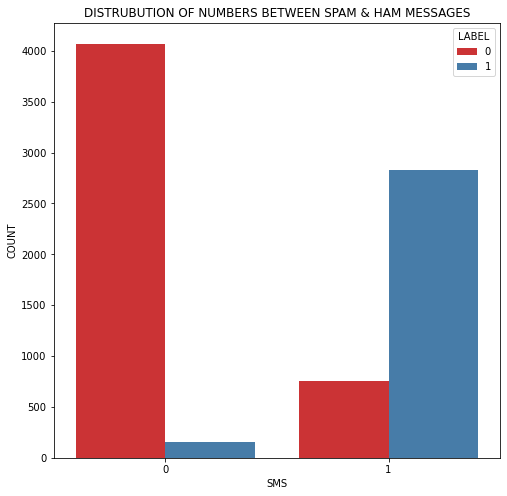

In [186]:
plt.figure(figsize=(8,8))
a = sns.countplot(x = 'NUMBERS' ,data =data , palette = ("Set1") , hue = 'LABEL')
b = plt.title('DISTRUBUTION OF NUMBERS BETWEEN SPAM & HAM MESSAGES')
b = plt.xlabel('SMS')
b = plt.ylabel('COUNT')
plt.show()

#### Insights
- It is evident that most of the Spam messages contain numbers, and majority of the Ham messages doesn't contain numbers.


# Data Cleaning

In [187]:
def clean_data (df) : 
    corpus = []
    stop_words = stopwords.words( "english")

    
    for i in list(df.values[:,:2]) :
                
        message = i[1].lower()
        
        wtk =word_tokenize(message)
        
        filtered_words = [word for word in wtk if word not in stop_words and word not in punctuation]
        
        message = ' '.join(filtered_words)
        
        corpus.append([message,i[0]])

    return corpus


corpus = clean_data(data)

# Modeling

In [188]:
X = [i[0] for i in corpus]
y = [i[1] for i in corpus]

In [189]:
X[:3]

['go jurong point crazy .. available bugis n great world la e buffet ... cine got amore wat ...',
 'ok lar ... joking wif u oni ...',
 "free entry 2 wkly comp win fa cup final tkts 21st may 2005. text fa 87121 receive entry question std txt rate c 's apply 08452810075over18 's"]

In [190]:
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(X).toarray()
feature_names = tfidf.get_feature_names()

In [191]:
X_train, X_test, y_train, y_test = train_test_split(vectors, y, test_size=0.2, random_state=42)

In [192]:
mnb = MultinomialNB()
cv = cross_val_score(mnb, X, y, scoring='f1', cv=10)
print('--- Average F1-Score for MNB model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for MNB model: nan ---
Standard Deviation: nan


In [193]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

print('Classification report for MNB model')
print(classification_report(y_test, y_pred))

Classification report for MNB model
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       973
           1       0.95      0.93      0.94       590

    accuracy                           0.95      1563
   macro avg       0.95      0.95      0.95      1563
weighted avg       0.95      0.95      0.95      1563



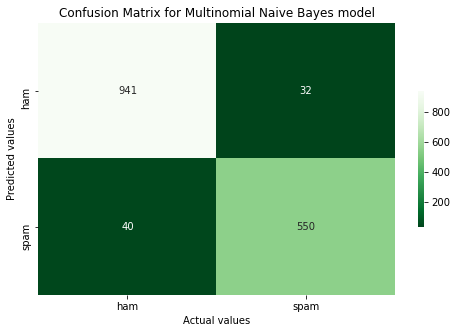

In [194]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cmap="Greens_r", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('Confusion Matrix for Multinomial Naive Bayes model')

In [195]:
def predict_spam (message) : 
    
    stop_words = stopwords.words( "english")
    wtk =word_tokenize(message)    
    filtered_words = [word for word in wtk if word not in stop_words and word not in punctuation]
    message = ' '.join(filtered_words)
    temp = tfidf.transform([message]).toarray()       
    prediction = mnb.predict(temp)
    
    if prediction[0] == 0 : return 'HAM MESSAGE'
    else : return 'SPAM MESSAGE'


In [196]:
predict_spam('K tell me anything about you.')

'HAM MESSAGE'

In [197]:
predict_spam('''WINNER!! As a valued network customer you have been selected to receivea £900 prize reward!
             To claim call 09061701461. Claim code KL341. Valid 12 hours only.''')

'SPAM MESSAGE'

In [198]:
inputMessage = input('Enter message to filtere :')
print('Your message :',inputMessage)
print('Output :' , predict_spam(inputMessage))

Your message : My name is Mohammed
Output : HAM MESSAGE
